In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import applications
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.image as mpimg
from PIL import Image
tf.compat.v1.disable_eager_execution()

In [2]:
#This is style image:
img1 = mpimg.imread("reference.jpeg")
# This is the content image:
img2 = mpimg.imread("content.jpeg")
styleimg = Image.fromarray(img1).resize((224, 224)) # This code results in resizing the style image:
contentimg = Image.fromarray(img2).resize((224, 224)) # This code results in resizing the content image:
content_array = np.asarray(contentimg,dtype="float32") 
content_array.shape #It prints the shape of content array in the form of (length, height, no of channels)

In [5]:
content_array = np.expand_dims(content_array, axis = 0) #This converts it in the form of (no of examples (1 in our case), len, height, no. of channels)
print(content_array.shape)
style_array = np.asarray(styleimg, dtype ="float32")
style_array = np.expand_dims(style_array, axis = 0)

(1, 224, 224, 3)


In [7]:
content_array[:,:,:,0]-=103.939 #R
content_array[:,:,:,1]-=116.779 #G
content_array[:,:,:,2]-=123.68 #B
content_array = content_array[:,:,:,::-1] #This converts it into BGR
style_array[:,:,:,0]-=103.939 #R
style_array[:,:,:,1]-=116.779 #G
style_array[:,:,:,2]-=123.68 #B
style_array = style_array[:,:,:,::-1] #This converts it into BGR
#Subtracting the mean RGB gave the best result as reported by paper.

In [8]:
content_img = keras.backend.variable(content_array)
style_img = keras.backend.variable(style_array)
newimg = keras.backend.placeholder((1,224,224,3))
input_tensor=keras.backend.concatenate([content_img,style_img,newimg],axis = 0)
model = VGG19(input_tensor = input_tensor, weights = "imagenet", include_top="false")
layers = dict([(layer.name, layer.output) for layer in model.layers])
content_weights =2
style_weight = 0.5
total_variation_weight = 0
loss = keras.backend.variable(0)

In [13]:
#This fucntion will define the loss in content: 
def content_loss(content, combination):
  return(keras.backend.sum(keras.backend.square(combination-content)))

layer_features = layers["block4_pool"]
content_image_features = layer_features[0,:,:,:]
combination_image_features = layer_features[2,:,:,:]
loss = loss + content_weights * content_loss(content_image_features, combination_image_features)

In [14]:
#This will give the style loss 
#Defining a gram matrix
def gram_matrix(x):
  #Here the shape of X will be 1,height,width,no of content
  features = keras.backend.batch_flatten(keras.backend.permute_dimensions(x,(2,0,1))) #Now the shape will be changed No of content,height,weight
  gram = keras.backend.dot(features,keras.backend.transpose(features))
  return(gram)

#Style loss
def style_loss(style, combination):
  S =gram_matrix(style)
  C =gram_matrix(combination)
  channels = 3
  size = 224*224
  return(keras.backend.sum(keras.backend.square(S-C))/(2*channels*size)**2)

In [17]:
feature_layers = ["block1_conv2", "block2_conv2", "block3_conv2"]
style_loss_1 = 0

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[0, :, :, :]  # Select the first element (index 0)
    combination_features = layer_features[2, :, :, :]  # Select the third element (index 2)

    sa = style_loss(style_features, combination_features)
    style_loss_1 += sa

final_style_loss = (style_loss_1 * style_weight) / len(feature_layers)
loss += final_style_loss

In [18]:
grads = keras.backend.gradients(loss, newimg)
# # newimg = tf.Variable(newimg)
# # With the following lines:
# with tf.GradientTape() as tape:
#     grads = tape.gradient(loss, newimg.value())
outputs = [loss]
outputs+=grads
f_output = keras.backend.function([newimg],outputs)
#Evaluate loss and gradients to be used in evaluator class
def eval_loss_and_grade(x):
  x = x.reshape((1,224,224,3))
  out = f_output([x])
  loss_value = out[0]
  grads_value = out[1].flatten().astype("float64")
  return(loss_value,grads_value)

In [19]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grads_value = eval_loss_and_grade(x)
        self.loss_value = loss_value
        self.grads_values = grads_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_values)
        self.loss_value = None
        self.grads_values = None
        return grads_values.flatten().astype("float64")


def eval_loss_and_grade(x):
    x = x.reshape((1, 224, 224, 3))
    out = f_output([x])
    loss_value = out[0]
    grads_value = out[1][0]
    return loss_value, grads_value

evaluator = Evaluator()
#Now we will do the optimization for the outcome image
x=np.random.uniform(0,225,(1,224,224,3)) -128
iterations = 20

Iteration: 1
Loss: 4671555600.0
Iteration: 2
Loss: 1752933400.0
Iteration: 3
Loss: 1092357500.0
Iteration: 4
Loss: 789920000.0
Iteration: 5
Loss: 634555000.0
Iteration: 6
Loss: 531797500.0
Iteration: 7
Loss: 454526400.0
Iteration: 8
Loss: 398071800.0
Iteration: 9
Loss: 355721950.0
Iteration: 10
Loss: 323849820.0
Iteration: 11
Loss: 294094620.0
Iteration: 12
Loss: 268228580.0
Iteration: 13
Loss: 248306110.0
Iteration: 14
Loss: 231196660.0
Iteration: 15
Loss: 215393180.0
Iteration: 16
Loss: 201284340.0
Iteration: 17
Loss: 189038780.0
Iteration: 18
Loss: 178195420.0
Iteration: 19
Loss: 168622340.0
Iteration: 20
Loss: 159598690.0


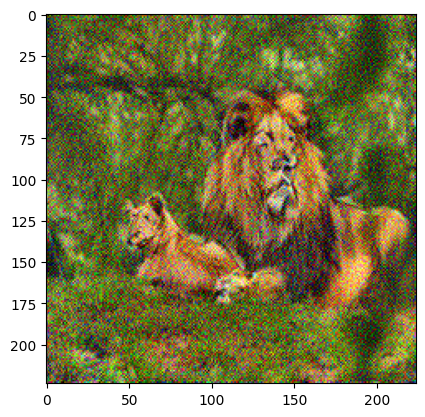

In [27]:
for i in range(iterations):
    print("Iteration:", i+1)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print("Loss:", min_val)

# Post-process the generated image
x = x.reshape((224, 224, 3))
x = x[:, :, ::-1]  # This line converts BGR to RGB

x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype("uint8")
plt.imshow(x)
plt.show()
outcome_img = Image.fromarray(x)
outcome_img.save("Outcome.jpeg")